In [22]:
import sys
sys.path.insert(0, "../src")
import example_helper as eh
import analysis_helper as ah
import msgpack
import zlib
import numpy as np
import datetime
import time
import matplotlib.pyplot as plt
import matplotlib.dates as md
from matplotlib.pyplot import figure
import pandas as pd
import seaborn as sns; sns.set()

# Get Data

In [23]:
# define the location of the input file
filename_augmento_topics = "../data/example_data/augmento_topics.msgpack.zlib"
filename_augmento_data = "../data/example_data/augmento_data.msgpack.zlib"
filename_bitmex_data = "../data/example_data/bitmex_data.msgpack.zlib"

# load the example data
all_data = eh.load_example_data(filename_augmento_topics,
                             filename_augmento_data,
                             filename_bitmex_data)
aug_topics, aug_topics_inv, t_aug_data, aug_data, t_price_data, price_data = all_data

In [24]:
all_topics = aug_data.T.astype(float)
#all_topics.shape

In [25]:
# calculate PNL for a given strategy
# if sentiment positive go long, else go short
# fees are assumed to be 0.75% (taker fee from BITMEX)

def strategy(price_data, signal_a, signal_b, window_1 = 24 * 7, window_2 = 24*7,buy_sell_fee = 0.0, pnl_0 = 1.0):    
    sent_score = ah.nb_calc_sentiment_score_a(signal_a,signal_b,window_1,window_2)
    pnl = ah.nb_backtest_a(price_data, sent_score, buy_sell_fee)
    return pnl

# PNL of various moving window size for a given combination of topics
def window_combination(price_data,top_a,top_b,days,buy_sell_fee=0.0075):
    total_comb = np.zeros(shape=(days,days))
    print("Calculating...")
    for i in range(0,days):
        for j in range(0,days):
            total_comb[i][j] = strategy(price_data,top_a,top_b,window_1=24*(i+1),window_2=24*(j+1),buy_sell_fee = buy_sell_fee)[-1]
    print("Done.")
    return total_comb
    

In [26]:
# for each combination of signals, generate PNL for the last period in data
total = np.zeros(shape=(93,93))
for i in range(0,len(all_topics)):
    for j in range(0,len(all_topics)):
        total[i][j] = strategy(price_data,all_topics[i],all_topics[j],window_1=24*7,window_2 = 24*7)[-1]
    print("Row " + str(i+1) + " out of 93...")
print("done")

Row 1 out of 93...
Row 2 out of 93...
Row 3 out of 93...
Row 4 out of 93...
Row 5 out of 93...
Row 6 out of 93...
Row 7 out of 93...
Row 8 out of 93...
Row 9 out of 93...
Row 10 out of 93...
Row 11 out of 93...
Row 12 out of 93...
Row 13 out of 93...
Row 14 out of 93...
Row 15 out of 93...
Row 16 out of 93...
Row 17 out of 93...
Row 18 out of 93...
Row 19 out of 93...
Row 20 out of 93...
Row 21 out of 93...
Row 22 out of 93...
Row 23 out of 93...
Row 24 out of 93...
Row 25 out of 93...
Row 26 out of 93...
Row 27 out of 93...
Row 28 out of 93...
Row 29 out of 93...
Row 30 out of 93...
Row 31 out of 93...
Row 32 out of 93...
Row 33 out of 93...
Row 34 out of 93...
Row 35 out of 93...
Row 36 out of 93...
Row 37 out of 93...
Row 38 out of 93...
Row 39 out of 93...
Row 40 out of 93...
Row 41 out of 93...
Row 42 out of 93...
Row 43 out of 93...
Row 44 out of 93...
Row 45 out of 93...
Row 46 out of 93...
Row 47 out of 93...
Row 48 out of 93...
Row 49 out of 93...
Row 50 out of 93...
Row 51 ou

In [27]:
# get all PNL in a dataframe
data = pd.DataFrame(total).rename(columns=aug_topics,index=aug_topics)
# given all combinations of signals, show the combinations that yield the highest PNL
c = data.abs()
s = c.unstack()
so_st = s.sort_values(kind="quicksort")
# specify n, a number of top combinations to be shown
t = so_st.tail(n=30).index

In [28]:
# labels for graphs and tables
columns_t = dict((y, x) for x, y in t).keys()
rows_t = dict((x, y) for x, y in t).keys()

In [29]:
# pick from the dataframes only the pairs of strategies that are within the top list
top = data[rows_t].loc[columns_t]

# Heat Map for top 30 pairs

In [30]:
# a sorted dataframe to get highest PNLs in the first rows
idx = pd.unique([i[1] for i in np.flip(t.values)])
col = pd.unique([i[0] for i in np.flip(t.values)])
sorted_df = data[col].loc[idx]

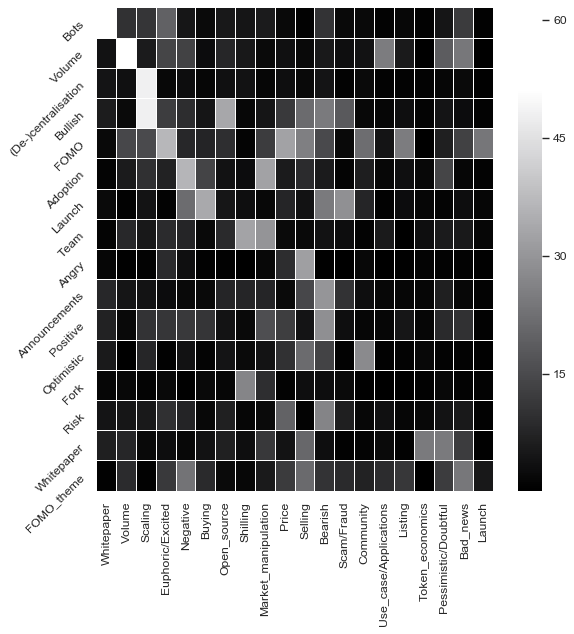

In [31]:
# plot a heat map with top 30 PNLs
# light colors indicate high, while dark colors low values
m = np.array(sorted_df)
cmap = sns.cubehelix_palette(50, hue=0.05, rot=0, light=0.0, dark=1.2, as_cmap=True)
figure(num=None, figsize=(8, 8), dpi=80, facecolor='w', edgecolor='k')
ax = sns.heatmap(m, linewidth=0.01, cmap=cmap)
ax.set_xticklabels(col, rotation=90)
ax.set_yticklabels(idx, rotation = 45)
plt.show()

# Testing for different windows sizes

## 1. same window size for rolling std and average

In [32]:
# recompute the NLP matrix for the above found combinations for window sizes from 1 to number of days specified
number_of_days = 30
top_n = 20
t_10 = so_st.tail(n=top_n).index
empty = np.zeros([top_n, number_of_days])
for j in range(len(t_10)):
    for days in range(1,(number_of_days+1)):    
        a = strategy(price_data,all_topics[aug_topics_inv[t_10[j][1]]],all_topics[aug_topics_inv[t_10[j][0]]],window_1=24*days,window_2=24*days)[-1]
        empty[j][days-1] = a

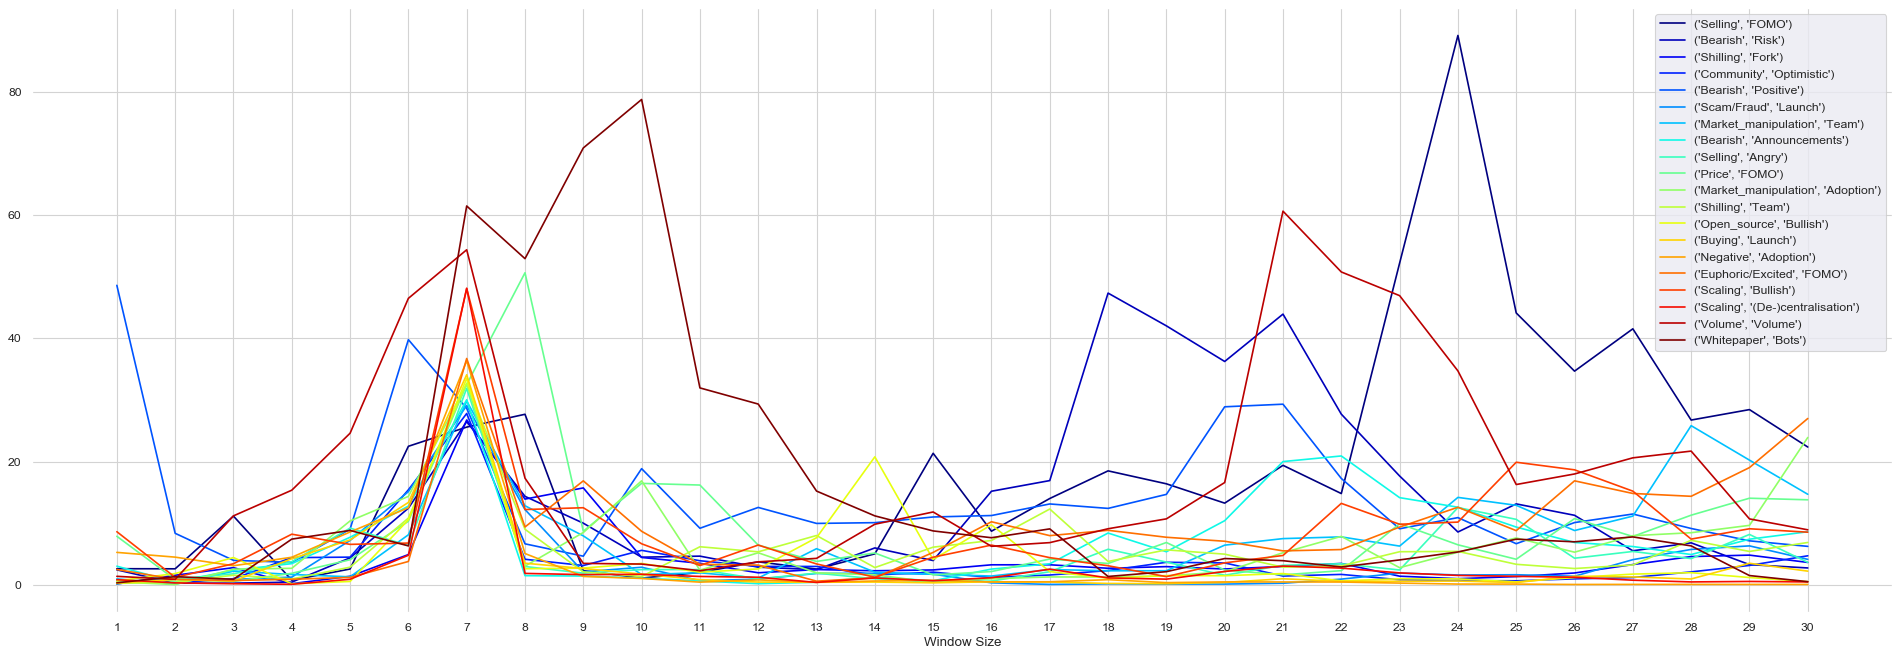

In [33]:
# plot the combinations for different window sizes
figure(num=None, figsize=(30, 10), dpi=80)
days_a = np.arange(number_of_days)
labels = t_10.values
cmap = plt.get_cmap('jet')
colors = cmap(np.linspace(0, 1.0,20))
ax = plt.gca()
ax.set_facecolor("white")
for i , label, color in zip(empty,labels,colors):
    plt.plot(days_a,i,label=label,color=color)
    plt.xticks(np.arange(number_of_days), np.arange(1,number_of_days+1))
    plt.legend()
    plt.xlabel("Window Size")
    plt.grid(color="lightgrey")


# Different rolling mean and std window sizes

From a chosen pair of topics, compute NLP for various rolling average and rolling std

#### example for 'Bots' and 'Whitepaper'

In [34]:
#specify tags
topic_a = 'Bots'
topic_b = 'Whitepaper'
top_b = all_topics[aug_topics_inv[topic_b]]
top_a = all_topics[aug_topics_inv[topic_a]]
total_s = window_combination(price_data,top_a,top_b,24)

Calculating...
Done.


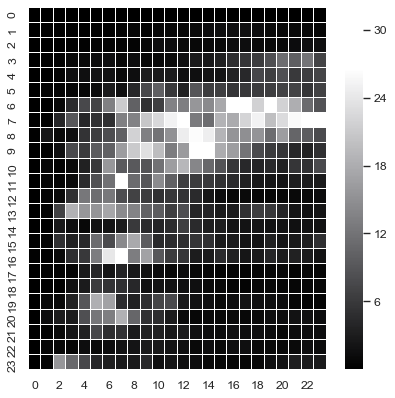

In [35]:
# plot
cmap = sns.cubehelix_palette(50, hue=0.05, rot=0, light=0.0, dark=1.2, as_cmap=True)
figure(num=None, figsize=(6, 6), dpi=80, facecolor='w', edgecolor='k')
ax = sns.heatmap(total_s, linewidth=0.01, cmap=cmap)
plt.show()

#### example for 'Bullish' and 'Bearish'

In [36]:
#specify tags
topic_a = 'Bullish'
topic_b = 'Bearish'
top_b = all_topics[aug_topics_inv[topic_b]]
top_a = all_topics[aug_topics_inv[topic_a]]
total_s = window_combination(price_data,top_a,top_b,24)

Calculating...
Done.


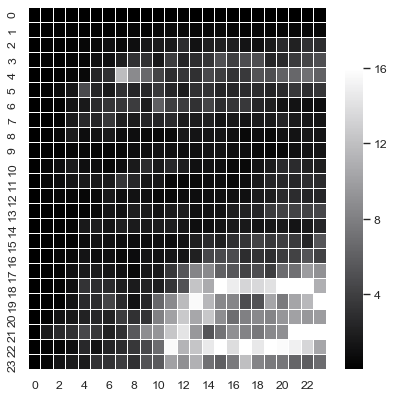

In [37]:
# plot
cmap = sns.cubehelix_palette(50, hue=0.05, rot=0, light=0.0, dark=1.2, as_cmap=True)
figure(num=None, figsize=(6, 6), dpi=80, facecolor='w', edgecolor='k')
ax = sns.heatmap(total_s, linewidth=0.01, cmap=cmap)
plt.show()